In [3]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

In [4]:
# Read NumPy data
infile_dir = 'graph_data'
signal_segment_data = np.load('../signal/' + infile_dir + '/signal_segment_data_reduced.npz')
signal_selection_data = np.load('../signal/' + infile_dir + '/signal_selection_data_reduced.npz')
cosmics_segment_data = np.load('../cosmics/' + infile_dir + '/cosmics_segment_data_reduced.npz')
cosmics_selection_data = np.load('../cosmics/' + infile_dir + '/cosmics_selection_data_reduced.npz')
BRN_segment_data = np.load('../BRN/' + infile_dir + '/BRN_segment_data_reduced.npz')
BRN_selection_data = np.load('../BRN/' + infile_dir + '/BRN_selection_data_reduced.npz')

print("Successfully loaded data!")

Successfully loaded data!


In [7]:
feature_names = ['TotalE', 'SignalVolE', 'FiducialVolE', 'MaxE', 'MaxELength', 'SignalVolEFrac', 'FiducialVolEFrac', 'pMaxE', 'CRTtop', 'CRTbottom', 'CRTleft', 'CRTright', 'CRTfront', 'CRTback', 'CRT']
signal_data = np.column_stack((signal_segment_data['aenergy'], signal_segment_data['senergy'], signal_segment_data['fenergy'],
                               signal_segment_data['lctes'], signal_segment_data['lctls'], signal_segment_data['psenergy'],
                               signal_segment_data['pfenergy'], signal_selection_data['pmaxe'], signal_selection_data['crttop'],
                               signal_selection_data['crtbottom'], signal_selection_data['crtleft'], signal_selection_data['crtright'],
                               signal_selection_data['crtfront'], signal_selection_data['crtback'], signal_selection_data['crt']))

cosmics_data = np.column_stack((cosmics_segment_data['aenergy'], cosmics_segment_data['senergy'], cosmics_segment_data['fenergy'],
                                cosmics_segment_data['lctes'], cosmics_segment_data['lctls'], cosmics_segment_data['psenergy'],
                                cosmics_segment_data['pfenergy'], cosmics_selection_data['pmaxe'], cosmics_selection_data['crttop'],
                                cosmics_selection_data['crtbottom'], cosmics_selection_data['crtleft'], cosmics_selection_data['crtright'],
                                cosmics_selection_data['crtfront'], cosmics_selection_data['crtback'], cosmics_selection_data['crt']))

BRN_data = np.column_stack((BRN_segment_data['aenergy'], BRN_segment_data['senergy'], BRN_segment_data['fenergy'],
                            BRN_segment_data['lctes'], BRN_segment_data['lctls'], BRN_segment_data['psenergy'],
                            BRN_segment_data['pfenergy'], BRN_selection_data['pmaxe'], BRN_selection_data['crttop'], BRN_selection_data['crtbottom'],
                            BRN_selection_data['crtleft'], BRN_selection_data['crtright'], BRN_selection_data['crtfront'], BRN_selection_data['crtback'],
                            BRN_selection_data['crt']))

sb_data = np.concatenate((signal_data, cosmics_data, BRN_data))
scosmics_data = np.concatenate((signal_data, cosmics_data))
sbrn_data = np.concatenate((signal_data, BRN_data))

sb_labels = np.concatenate((np.ones(len(signal_data)), np.zeros(len(cosmics_data)), np.zeros(len(BRN_data))))
scosmics_labels = np.concatenate((np.ones(len(signal_data)), np.zeros(len(cosmics_data))))
sbrn_labels = np.concatenate((np.ones(len(signal_data)), np.zeros(len(BRN_data))))

sb_weights = np.concatenate((np.full(len(signal_data), 116.5/99990), np.full(len(cosmics_data), 54), np.full(len(BRN_data), 0.3192)))
scosmics_weights = np.concatenate((np.full(len(signal_data), 116.5/99990), np.full(len(cosmics_data), 54)))
sbrn_weights = np.concatenate((np.full(len(signal_data), 116.5/99990), np.full(len(BRN_data), 0.3192)))

sb_train = xgb.DMatrix(data=sb_data, label=sb_labels, weight=sb_weights, feature_names=feature_names)
scosmics_train = xgb.DMatrix(data=scosmics_data, label=scosmics_labels, weight=scosmics_weights, feature_names=feature_names)
sbrn_train = xgb.DMatrix(data=sbrn_data, label=sbrn_labels, weight=sbrn_weights, feature_names=feature_names)

In [8]:
param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 10  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 0.8 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make

In [9]:
sb_booster = xgb.train(param, sb_train, num_boost_round=num_trees)
scosmics_booster = xgb.train(param, scosmics_train, num_boost_round=num_trees)
sbrn_booster = xgb.train(param, sbrn_train, num_boost_round=num_trees)

In [10]:
sb_predictions = sb_booster.predict(sb_train)
scosmics_predictions = scosmics_booster.predict(scosmics_train)
sbrn_predictions = sbrn_booster.predict(sbrn_train)

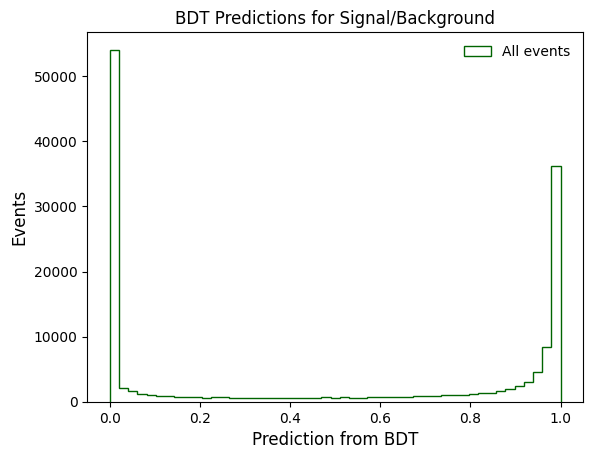

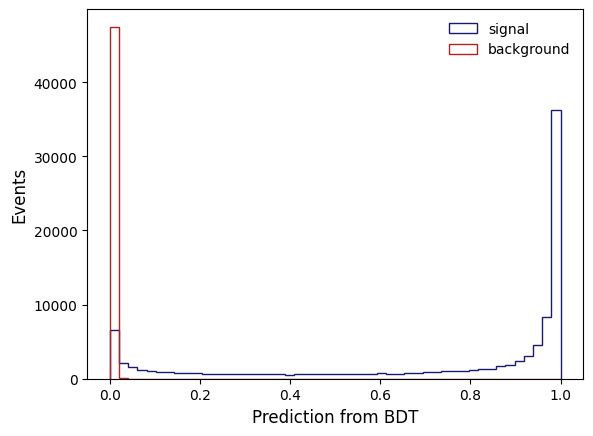

In [11]:
# plot all predictions (both signal and background)
plt.figure()
plt.hist(sb_predictions, bins=np.linspace(0,1,50), histtype='step', color='darkgreen', label='All events')

# make the plot readable
plt.xlabel('Prediction from BDT', fontsize=12)
plt.ylabel('Events', fontsize=12)
plt.legend(frameon=False)
plt.title('BDT Predictions for Signal/Background')

# plot signal and background separately
plt.figure()
plt.hist(sb_predictions[sb_train.get_label().astype(bool)], bins=np.linspace(0,1,50),
         histtype='step', color='midnightblue',label='signal')
plt.hist(sb_predictions[~(sb_train.get_label().astype(bool))], bins=np.linspace(0,1,50),
         histtype='step', color='firebrick', label='background')

# make the plot readable
plt.xlabel('Prediction from BDT', fontsize=12)
plt.ylabel('Events', fontsize=12)
plt.legend(frameon=False)

In [12]:
def signal(predictions, train, cut):
    n = 0
    for pred in predictions[train.get_label().astype(bool)]:
        if pred > cut:
            n += 1
    return (n / len(predictions[train.get_label().astype(bool)]))

def background(predictions, train, cut):
    n = 0
    for pred in predictions[~(train.get_label().astype(bool))]:
        if pred > cut:
            n += 1
    return n / len(predictions[~(train.get_label().astype(bool))])

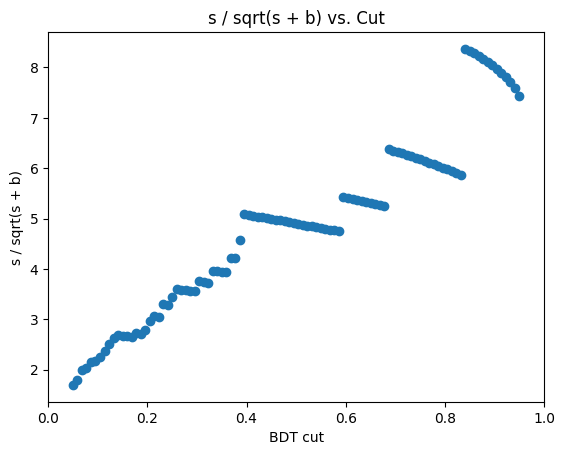

In [13]:
x = np.linspace(0.05, 0.95, 100)
y = [(signal(sb_predictions, sb_train, cut) * 116.5 / np.sqrt(signal(sb_predictions, sb_train, cut) * 116.5 + background(sb_predictions, sb_train, cut) * 3570778.356)) for cut in x]

plt.scatter(x, y)
plt.xlabel('BDT cut')
plt.ylabel('s / sqrt(s + b)')
plt.title('s / sqrt(s + b) vs. Cut')
plt.xlim(0, 1)

plt.show()

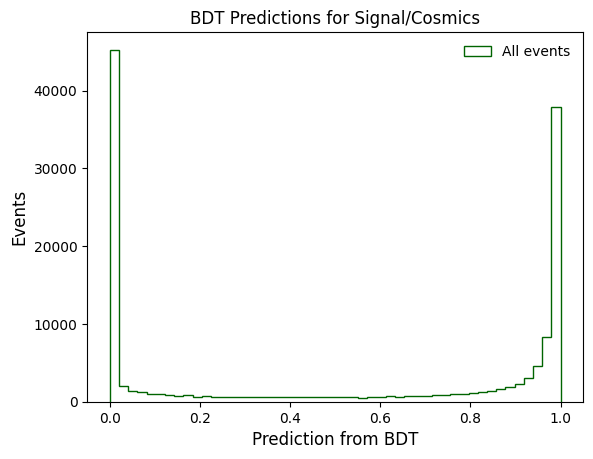

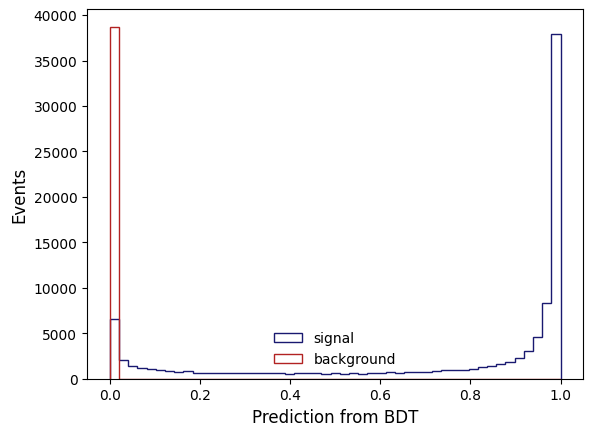

In [14]:
# plot all predictions (both signal and cosmics)
plt.figure()
plt.hist(scosmics_predictions, bins=np.linspace(0,1,50), histtype='step', color='darkgreen', label='All events')

# make the plot readable
plt.xlabel('Prediction from BDT', fontsize=12)
plt.ylabel('Events', fontsize=12)
plt.legend(frameon=False)
plt.title('BDT Predictions for Signal/Cosmics')

# plot signal and cosmics separately
plt.figure()
plt.hist(scosmics_predictions[scosmics_train.get_label().astype(bool)], bins=np.linspace(0,1,50),
         histtype='step', color='midnightblue',label='signal')
plt.hist(scosmics_predictions[~(scosmics_train.get_label().astype(bool))], bins=np.linspace(0,1,50),
         histtype='step', color='firebrick', label='background')

# make the plot readable
plt.xlabel('Prediction from BDT', fontsize=12)
plt.ylabel('Events', fontsize=12)
plt.legend(frameon=False)

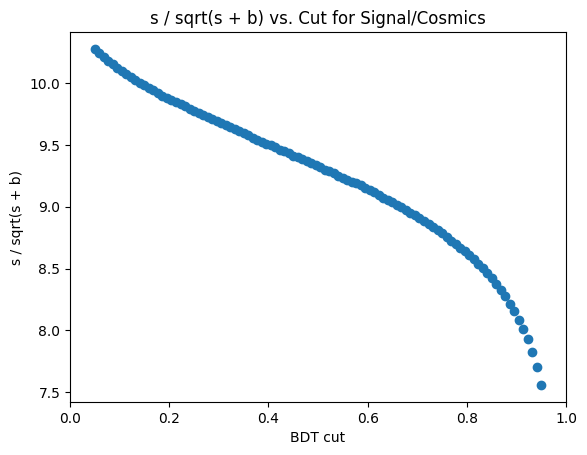

In [15]:
x = np.linspace(0.05, 0.95, 100)
y = [(signal(scosmics_predictions, scosmics_train, cut) * 116.5 / np.sqrt(signal(scosmics_predictions, scosmics_train, cut) * 116.5 + background(scosmics_predictions, scosmics_train, cut) * 3510432)) for cut in x]

plt.scatter(x, y)
plt.xlabel('BDT cut')
plt.ylabel('s / sqrt(s + b)')
plt.title('s / sqrt(s + b) vs. Cut for Signal/Cosmics')
plt.xlim(0, 1)

plt.show()

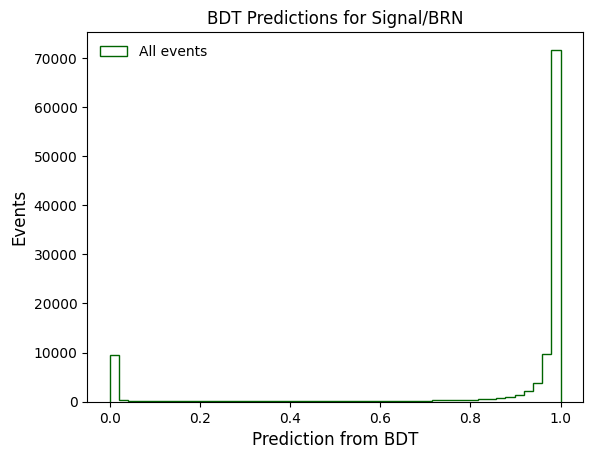

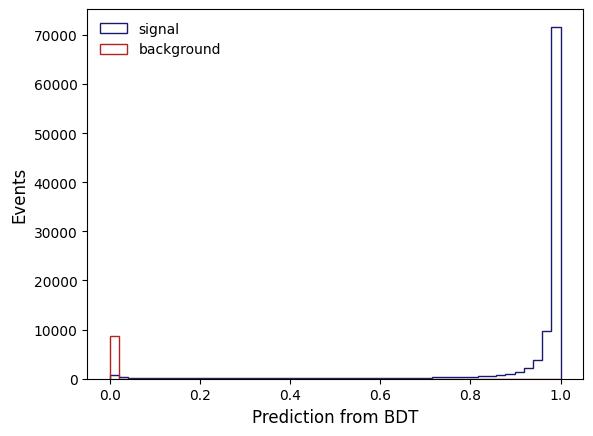

In [16]:
# plot all predictions (both signal and BRN)
plt.figure()
plt.hist(sbrn_predictions, bins=np.linspace(0,1,50), histtype='step', color='darkgreen', label='All events')

# make the plot readable
plt.xlabel('Prediction from BDT', fontsize=12)
plt.ylabel('Events', fontsize=12)
plt.legend(frameon=False)
plt.title('BDT Predictions for Signal/BRN')

# plot signal and cosmics separately
plt.figure()
plt.hist(sbrn_predictions[sbrn_train.get_label().astype(bool)], bins=np.linspace(0,1,50),
         histtype='step', color='midnightblue',label='signal')
plt.hist(sbrn_predictions[~(sbrn_train.get_label().astype(bool))], bins=np.linspace(0,1,50),
         histtype='step', color='firebrick', label='background')

# make the plot readable
plt.xlabel('Prediction from BDT', fontsize=12)
plt.ylabel('Events', fontsize=12)
plt.legend(frameon=False)

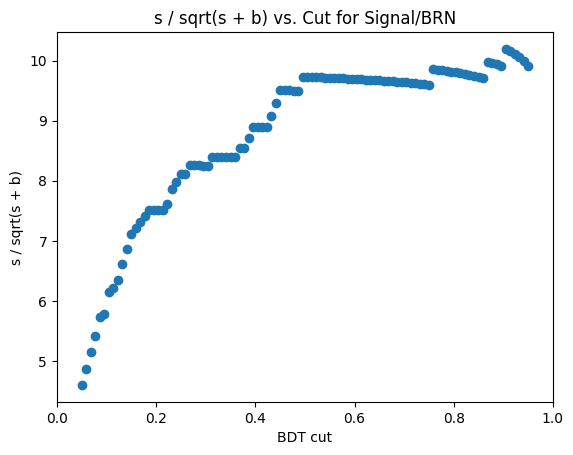

In [17]:
x = np.linspace(0.05, 0.95, 100)
y = [(signal(sbrn_predictions, sbrn_train, cut) * 116.5 / np.sqrt(signal(sbrn_predictions, sbrn_train, cut) * 116.5 + background(sbrn_predictions, sbrn_train, cut) * 60346.356)) for cut in x]

plt.scatter(x, y)
plt.xlabel('BDT cut')
plt.ylabel('s / sqrt(s + b)')
plt.title('s / sqrt(s + b) vs. Cut for Signal/BRN')
plt.xlim(0, 1)

plt.show()